# **1 Data Cleaning and Preprocessing**

In [ ]:
import pandas as pd
import re
from dateutil import parser

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
  df=pd.read_pickle("/content/drive/MyDrive/Earnings call prediction/motley-fool-data.pkl")
except Exception as e:
  print(f"Error : {e}")


In [ ]:
df.columns

In [ ]:
print(f"Data shape: {df.shape}")
df.head(5)

In [ ]:
def parse_date(date_str):
  try:
    clean_str=re.sub(r"\sE[DS]?T","",str(date_str))
    return parser.parse(clean_str)
  except:
    return None
df["Timestamp"]=df["date"].apply(parse_date)
df.head(10)

In [ ]:
df=df.dropna(subset=["Timestamp"])
df.shape

In [ ]:
df["Date_only"]=df["Timestamp"].dt.normalize()
df.head(5)

In [ ]:
def clean_transcript(text):
  if not isinstance(text,str):
    return ""
  text = re.sub(r'(Prepared Remarks:|Questions and Answers:)', '', text, flags=re.IGNORECASE)   #headers-Prepared remarks, Q&A
  text = re.sub(r'Operator\n.*?\n', '', text, flags=re.IGNORECASE)   #operator word
  text = re.sub(r'\s+', ' ', text).strip()  #extra whitespace
  return text
df["Clean_Text"]=df['transcript'].apply(clean_transcript)
df["word_count"]=df["Clean_Text"].apply(lambda x: len(str(x).split()))
df=df[df["word_count"]>100]      #keeping text word count >100, deleting short or cancelled calls
output_path="/content/drive/MyDrive/Earnings call prediction/cleaned_transcripts.pkl"
df.to_pickle(output_path)
print(df.shape)
df.head(5)

# **2 Stock Price Reaction**

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
from datetime import timedelta
import time
import pandas as pd

In [ ]:
df=pd.read_pickle("/content/drive/MyDrive/Earnings call prediction/cleaned_transcripts.pkl")

In [ ]:
earliest_date = df['Date_only'].min()
print(f"Earliest Transcript Date found: {earliest_date}")
start_date_dynamic=(earliest_date-pd.Timedelta(days=30)).strftime("%Y-%m-%d")
print(f"Fetching stock history from: {start_date_dynamic}")

In [ ]:
def clean_ticker(ticker_str):
  t=str(ticker_str).upper().strip()
  if ":" in t:    #if ticker is NASDAQ:AAPL
    t=t.split(":")[1].strip()
  t=t.replace("$","")
  return t
df["ticker_clean"]=df['ticker'].apply(clean_ticker)
print(f"unique tickers: {df["ticker_clean"].unique().tolist()}")

In [ ]:
# This uses 'regex=False' to search for the literal '$' character
print(f"Number of rows in 'ticker_clean' still containing '$': {df['ticker_clean'].str.contains('$', regex=False).sum()}")

In [ ]:
price_data={}
def get_price_reaction(row):
  ticker=row["ticker_clean"]
  call_date=row["Date_only"]
  if not ticker or not isinstance(ticker, str): return None
  if ticker not in price_data:
    try:
      stock=yf.Ticker(ticker)
      hist=stock.history(start=start_date_dynamic,end=None)
      if hist.empty:
        price_data[ticker] = None
        return None
      hist.index=hist.index.tz_localize(None)
      price_data[ticker]=hist
    except Exception as e:
      print(f"Error on: {ticker} Error:{e}")
      price_data[ticker]=None
      return None
  hist=price_data[ticker]
  if hist is None or hist.empty:
    return None
  try:
    if call_date<hist.index.min() or call_date>hist.index.max():
      return None
    idx=hist.index.get_indexer([call_date],method="nearest")[0]
    if idx+1>=len(hist):
      return None
    day_0=hist.iloc[idx]
    day_1=hist.iloc[idx+1]
    price_change=(day_1["Close"]-day_0["Open"])/day_0["Open"]
    return price_change
  except Exception:
    return None

print(f"Fetching data")
df["Price_change"]=df.apply(get_price_reaction,axis=1)
df.head(5)

In [ ]:
num_failed_fetches = df['Price_change'].isnull().sum()
print(f"Number of rows where Price_change could not be fetched: {num_failed_fetches}")

In [ ]:
df_cleaned = df.dropna(subset=['Price_change']).copy()
print(f"New DataFrame shape after dropping rows: {df_cleaned.shape}")

In [ ]:
df.head(5)

In [ ]:
original_df_path="/content/drive/MyDrive/Earnings call prediction/original_stock_price_reaction.csv"
final_df_path="/content/drive/MyDrive/Earnings call prediction/cleaned_stock_price_reaction.csv"   #for model training
df.to_csv(original_df_path,index=False)
df_cleaned.to_csv(final_df_path,index=False)

# **3 Exploratory Data Analysis**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_analysis=pd.read_csv("/content/drive/MyDrive/Earnings call prediction/cleaned_stock_price_reaction.csv")
df_analysis.head(5)

In [ ]:
print(df_analysis.shape)
df_analysis.columns

In [ ]:
df_analysis['Price_change'].describe()

In [ ]:
extreme_gain_count=df_analysis[df_analysis["Price_change"]>0.1].shape[0]
extreme_loss_count=df_analysis[df_analysis["Price_change"]<-0.1].shape[0]
print(f"No. of Earning calls resulting extreme gain : {extreme_gain_count}")
print(f"No. of Earning calls resulting extreme loss : {extreme_loss_count}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
CURRENT_THRESHOLD = 0.10
LOWER_THRESHOLD = 0.05

plt.figure(figsize=(12,6))
sns.histplot(df_analysis["Price_change"],bins=100,kde=True,edgecolor="none",color="skyblue",alpha=0.7)
plt.axvline(CURRENT_THRESHOLD,color="red",linestyle="--",linewidth=2,label=f"+{CURRENT_THRESHOLD*100:.0f}% Threshold (10%)")
plt.axvline(-CURRENT_THRESHOLD,color="red",linestyle="--",linewidth=2,label=f"-{CURRENT_THRESHOLD*100:.0f}% Threshold (10%)")

plt.axvline(LOWER_THRESHOLD,color="green",linestyle=":",linewidth=1,label=f"+{LOWER_THRESHOLD*100:.0f}% Test Threshold (5%)")
plt.axvline(-LOWER_THRESHOLD,color="green",linestyle=":",linewidth=1,label=f"-{LOWER_THRESHOLD*100:.0f}% Test Threshold (5%)")

plt.title("Distribution of Price change day0 open to day 1 close",fontsize=16)
plt.xlabel("Price_change (in decimal)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.grid(axis="y",alpha=0.5)
plt.legend()
plt.show()

In [ ]:
THRESHOLD=0.05
conditions=[(df_analysis["Price_change"]>=THRESHOLD), (df_analysis["Price_change"]<=-THRESHOLD)]
values=["Gain","Loss"]
df_analysis["Target_Class"]=np.select(condlist=conditions,choicelist=values,default="Neutral")
print("Target_Class column created")

In [ ]:
class_distribution_counts=df_analysis['Target_Class'].value_counts()
class_distribution_percent=class_distribution_counts.apply(lambda x:f"{(x/class_distribution_counts.sum())*100:2f}%")
print(f"class_distribution_counts are {class_distribution_counts}")
print(f"Class distribution percentage are {class_distribution_percent}")

# **4 Feature Engineering**

**Temporal Features**

In [ ]:
df_analysis['Date_only']=pd.to_datetime(df_analysis["Date_only"])
df_analysis["DateOfWeek"]=df_analysis["Date_only"].dt.day_of_week
df_analysis["Month"]=df_analysis["Date_only"].dt.month
df_analysis["Quarter"]=df_analysis["Date_only"].dt.quarter

**bold text**

In [ ]:
!pip install category_encoders
from category_encoders import TargetEncoder

df_analysis["Target_gain_flag"]=(df_analysis["Target_Class"]=="Gain").astype(int)
encoder=TargetEncoder(cols=["ticker_clean"])
df_analysis["Ticker_gain_prob"]=encoder.fit_transform(df_analysis["ticker_clean"],df_analysis["Target_gain_flag"])

df_analysis["Target_loss_flag"]=(df_analysis["Target_Class"]=="Loss").astype(int)
encoder=TargetEncoder(cols=["ticker_clean"])
df_analysis["Ticker_loss_prob"]=encoder.fit_transform(df_analysis["ticker_clean"],df_analysis["Target_loss_flag"])
df_analysis.head(5)

In [ ]:
df_analysis.drop(columns=["Target_gain_flag","Target_loss_flag","ticker_clean"],inplace=True)
df_analysis.head(5)

In [ ]:
path="/content/drive/MyDrive/Earnings call prediction/final_dataframe_after_FE.csv"
df_analysis.to_csv(path)

**Sentiment scores**

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_analysis=pd.read_csv("/content/drive/MyDrive/Earnings Call Prediction/final_dataframe_after_FE.csv")

In [3]:
!pip install transformers torch tqdm
! pip install torch==2.9.0 'torch_xla[tpu]==2.9.0' -f https://storage.googleapis.com/libtpu-releases/index.html
import torch_xla.core.xla_model as xm
import torch
device = xm.xla_device()
print("TPU device connected:", device)
t1 = torch.randn(3, 3, device=device)
t2 = torch.randn(3, 3, device=device)
print("\nExample computation on TPU:", t1 + t2)

import torch
from transformers import pipeline
from tqdm.auto import tqdm
import pandas as pd

classifier = pipeline("text-classification", model="ProsusAI/finbert", return_all_scores=True, device=device)

# Preparing Data
texts = df_analysis['Clean_Text'].astype(str).tolist()
batch_size = 32
results = []

print(f"Starting inference on {len(texts)} rows...")
for i in tqdm(range(0, len(texts), batch_size)):
  batch = texts[i : i + batch_size]
  batch_results = classifier(batch, truncation=True, max_length=512)
  results.extend(batch_results)

# Parsing Results into Columns. FinBERT outputs a list of dictionaries. Mapping them to columns
pos_scores = []
neg_scores = []
neu_scores = []

for row_result in results:
  scores_dict = {item['label']: item['score'] for item in row_result}
  pos_scores.append(scores_dict.get('positive', 0))
  neg_scores.append(scores_dict.get('negative', 0))
  neu_scores.append(scores_dict.get('neutral', 0))

#Adding to DataFrame
df_analysis['FinBERT_Positive'] = pos_scores
df_analysis['FinBERT_Negative'] = neg_scores
df_analysis['FinBERT_Neutral'] = neu_scores

df_analysis.drop(columns=['Clean_Text'], inplace=True)

print("Success! FinBERT scores added.")

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html


/tmp/ipython-input-1725248875.py:5: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


TPU device connected: xla:0

Example computation on TPU: tensor([[ 0.3355, -1.4628, -3.2610],
        [-1.4656,  0.3196, -2.8766],
        [ 0.8667, -1.5060,  0.7125]], device='xla:0')


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use xla:0


Starting inference on 15055 rows...


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/471 [00:00<?, ?it/s]

Success! FinBERT scores added.


In [4]:
df_analysis.head(5)

,Unnamed: 0,date,exchange,q,ticker,transcript,Timestamp,Date_only,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,Ticker_gain_prob,Ticker_loss_prob,FinBERT_Positive,FinBERT_Negative,FinBERT_Neutral
0,0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,5623,0.035078,Neutral,3,8,3,0.134823,0.215544,0.146988,0.012653,0.840358
1,1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,4755,0.116154,Gain,3,7,3,0.210214,0.212302,0.910005,0.010605,0.079389
2,2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,8917,0.142022,Gain,2,10,4,0.261479,0.176718,0.878131,0.012376,0.109493
3,3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,8286,0.029891,Neutral,2,11,4,0.210214,0.181707,0.727205,0.122016,0.150779
4,4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,4611,0.249623,Gain,2,8,3,0.253273,0.199769,0.755221,0.136653,0.108126


In [5]:
df_analysis.columns

Index(['Unnamed: 0', 'date', 'exchange', 'q', 'ticker', 'transcript',
       'Timestamp', 'Date_only', 'word_count', 'Price_change', 'Target_Class',
       'DateOfWeek', 'Month', 'Quarter', 'Ticker_gain_prob',
       'Ticker_loss_prob', 'FinBERT_Positive', 'FinBERT_Negative',
       'FinBERT_Neutral'],
      dtype='object')

In [7]:
df_analysis.drop(columns=['Unnamed: 0',"Ticker_gain_prob","Ticker_loss_prob"],inplace=True)
df_analysis.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,FinBERT_Positive,FinBERT_Negative,FinBERT_Neutral
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,5623,0.035078,Neutral,3,8,3,0.146988,0.012653,0.840358
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,4755,0.116154,Gain,3,7,3,0.910005,0.010605,0.079389
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,8917,0.142022,Gain,2,10,4,0.878131,0.012376,0.109493
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,8286,0.029891,Neutral,2,11,4,0.727205,0.122016,0.150779
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,4611,0.249623,Gain,2,8,3,0.755221,0.136653,0.108126


In [8]:
def clean_ticker(ticker_str):
  t=str(ticker_str).upper().strip()
  if ":" in t:    #if ticker is NASDAQ:AAPL
    t=t.split(":")[1].strip()
  t=t.replace("$","")
  return t
df_analysis["ticker_clean"]=df_analysis['ticker'].apply(clean_ticker)
print(f"unique tickers: {df_analysis["ticker_clean"].unique().tolist()}")

unique tickers: ['BILI', 'GFF', 'LRCX', 'BBSI', 'CSTE', 'GDOT', 'KAR', 'EPAC', 'ABM', 'SGHC', 'SJM', 'URBN', 'HESM', 'SPOK', 'TSM', 'GNW', 'WPP', 'DXCM', 'EME', 'EEFT', 'ARAY', 'ZBRA', 'ROST', 'STZ', 'NET', 'HZO', 'LZB', 'USPH', 'MRNA', 'MELI', 'CDNS', 'VIV', 'NTCT', 'U', 'RUSHA', 'DTM', 'VCEL', 'MSTR', 'CSIQ', 'AAPL', 'CENT', 'FLNT', 'ACLS', 'GEO', 'DFIN', 'GOTU', 'MT', 'SHOP', 'EL', 'LGIH', 'EBS', 'REGN', 'EAF', 'META', 'HRB', 'STRS', 'TTE', 'FCNCA', 'OTIS', 'DHI', 'HLT', 'TLRY', 'ALGN', 'F', 'ADNT', 'PPG', 'AL', 'MKL', 'INBK', 'LILAK', 'SXC', 'CNI', 'BX', 'CMC', 'GNRC', 'BABA', 'OPRX', 'MOD', 'LAMR', 'TRV', 'LOPE', 'OCFT', 'HUN', 'TGT', 'SBSW', 'DB', 'MRCY', 'AI', 'FCN', 'PSMT', 'LITE', 'HCAT', 'KO', 'CMLS', 'OOMA', 'MVIS', 'BJRI', 'AGNC', 'TTWO', 'AMZN', 'IMOS', 'ROKU', 'CGEN', 'ONTO', 'MNKD', 'HR', 'CLF', 'SITM', 'OLED', 'COHR', 'ABR', 'WGO', 'APAM', 'CASH', 'MSA', 'GPI', 'CYD', 'ZEUS', 'WFC', 'NGD', 'PRI', 'CB', 'ANET', 'ARRY', 'SEER', 'KMB', 'GPRO', 'VVV', 'SNAP', 'OKTA', 'NUE',

In [9]:
df_analysis.head(5)

,date,exchange,q,ticker,transcript,Timestamp,Date_only,word_count,Price_change,Target_Class,DateOfWeek,Month,Quarter,FinBERT_Positive,FinBERT_Negative,FinBERT_Neutral,ticker_clean
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",2020-08-27 21:00:00,2020-08-27,5623,0.035078,Neutral,3,8,3,0.146988,0.012653,0.840358,BILI
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,2020-07-30 16:30:00,2020-07-30,4755,0.116154,Gain,3,7,3,0.910005,0.010605,0.079389,GFF
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-23 17:00:00,2019-10-23,8917,0.142022,Gain,2,10,4,0.878131,0.012376,0.109493,LRCX
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",2019-11-06 12:00:00,2019-11-06,8286,0.029891,Neutral,2,11,4,0.727205,0.122016,0.150779,BBSI
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,2019-08-07 08:30:00,2019-08-07,4611,0.249623,Gain,2,8,3,0.755221,0.136653,0.108126,CSTE


In [10]:
df_analysis.columns

Index(['date', 'exchange', 'q', 'ticker', 'transcript', 'Timestamp',
       'Date_only', 'word_count', 'Price_change', 'Target_Class', 'DateOfWeek',
       'Month', 'Quarter', 'FinBERT_Positive', 'FinBERT_Negative',
       'FinBERT_Neutral', 'ticker_clean'],
      dtype='object')

In [11]:
path="/content/drive/MyDrive/Earnings Call Prediction/Dataframe_after_finbert.csv"
df_analysis.to_csv(path,index=False)

In [12]:
from sklearn.model_selection import train_test_split
cols_to_drop = [
    "Target_Class",
    "Price_change",
    "Date_only",
    "date",
    "Timestamp",
    "transcript",
    "exchange",
    "q",
    "ticker",
    "word_count"
]

X = df_analysis.drop(columns=[c for c in cols_to_drop if c in df_analysis.columns])
y = df_analysis["Target_Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")
print("\nFinal Features in X_train:", X_train.columns.tolist())

Training data size: 10538
Test data size: 4517

Final Features in X_train: ['DateOfWeek', 'Month', 'Quarter', 'FinBERT_Positive', 'FinBERT_Negative', 'FinBERT_Neutral', 'ticker_clean']


In [14]:
import pandas as pd
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_path="/content/drive/MyDrive/Earnings Call Prediction/train_dataset.csv"
test_path="/content/drive/MyDrive/Earnings Call Prediction/test_dataset.csv"
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Train and Test datasets saved successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train and Test datasets saved successfully!
Train shape: (10538, 8)
Test shape: (4517, 8)


In [15]:
!pip install category_encoders
from category_encoders import TargetEncoder

gain_encoder = TargetEncoder(cols=['ticker_clean'])
loss_encoder = TargetEncoder(cols=['ticker_clean'])

y_train_gain = (y_train == 'Gain').astype(int)
y_train_loss = (y_train == 'Loss').astype(int)

# FITTING on X_train, TRANSFORM X_train
X_train['Ticker_Gain_Prob'] = gain_encoder.fit_transform(X_train['ticker_clean'], y_train_gain)
X_train['Ticker_Loss_Prob'] = loss_encoder.fit_transform(X_train['ticker_clean'], y_train_loss)

# TRANSFORM X_test
X_test['Ticker_Gain_Prob'] = gain_encoder.transform(X_test['ticker_clean'])
X_test['Ticker_Loss_Prob'] = loss_encoder.transform(X_test['ticker_clean'])

X_train.drop(columns=['ticker_clean'], inplace=True)
X_test.drop(columns=['ticker_clean'], inplace=True)

print("Target Encoding done correctly! No data leakage.")
print("X_train columns:", X_train.columns.tolist())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 133.9 MB/s eta 0:00:00
Target Encoding done correctly! No data leakage.
X_train columns: ['DateOfWeek', 'Month', 'Quarter', 'FinBERT_Positive', 'FinBERT_Negative', 'FinBERT_Neutral', 'Ticker_Gain_Prob', 'Ticker_Loss_Prob']


# **5.Feature Scaling**

In [16]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

# Fitting on Train, Transforming Train
X_train_scaled = scaler.fit_transform(X_train)
# Transforming Test
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("Data Scaling Complete.")

# SAVING THE COMPONENTS for Streamlit ---
# Save Encoders
joblib.dump(gain_encoder, 'ticker_gain_encoder.joblib')
joblib.dump(loss_encoder, 'ticker_loss_encoder.joblib')
# Save Scaler (
joblib.dump(scaler, 'standard_scaler.joblib')

print("Encoders and Scaler saved to .joblib files.")

Data Scaling Complete.
Encoders and Scaler saved to .joblib files.


In [19]:
import pandas as pd

train_final_df=X_train_scaled.copy()
test_final_df=X_test_scaled.copy()

# Adding the Target column to them to save
train_final_df['Target_Class'] = y_train.reset_index(drop=True)
test_final_df['Target_Class'] = y_test.reset_index(drop=True)

train_final_df.to_csv("/content/drive/MyDrive/Earnings Call Prediction/train_scaled_ready.csv", index=False)
test_final_df.to_csv("/content/drive/MyDrive/Earnings Call Prediction/test_scaled_ready.csv", index=False)

print("Scaled data saved! You are safe to start Hyperparameter Tuning.")

Scaled data saved! You are safe to start Hyperparameter Tuning.


# **6 Model Training**

In [21]:
!pip install xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import joblib

# Encoding Target Labels (Gain/Loss/Neutral -> 0/1/2)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Saving the Label Encoder for streamlit
joblib.dump(le, 'target_label_encoder.joblib')
print("Target Labels encoded and encoder saved.")

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initializing the Model
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

#Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Tuning...")
random_search.fit(X_train_scaled, y_train_encoded)

print("\nTuning Complete!")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Weighted F1-Score: {random_search.best_score_:.4f}")

# Saving the Best Model
best_model = random_search.best_estimator_
joblib.dump(best_model, 'final_xgb_model.joblib')
print("Best model saved as 'final_xgb_model.joblib'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.5 MB/s eta 0:00:00
Target Labels encoded and encoder saved.
Starting Hyperparameter Tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning Complete!
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best Weighted F1-Score: 0.6920
Best model saved as 'final_xgb_model.joblib'


In [22]:
X_train_scaled.shape

(10538, 8)

# **7 Model Testing and Evaluation**


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Gain       0.33      0.24      0.28       856
        Loss       0.34      0.28      0.31       869
     Neutral       0.70      0.79      0.74      2792

    accuracy                           0.59      4517
   macro avg       0.46      0.44      0.44      4517
weighted avg       0.56      0.59      0.57      4517



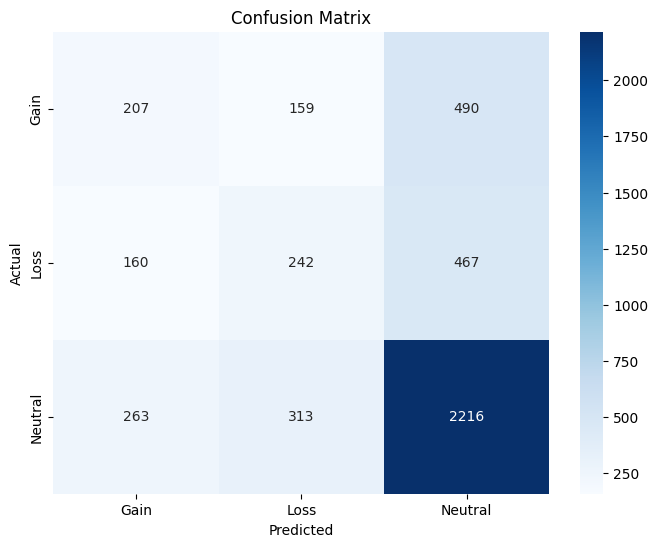

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test_scaled)
# Converting numerical predictions back to labels (0/1/2 -> Gain/Loss/Neutral)
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(y_pred)

print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test_decoded, y_pred_decoded))

cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=['Gain', 'Loss', 'Neutral'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Gain', 'Loss', 'Neutral'],
            yticklabels=['Gain', 'Loss', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **8 Feature Importance**

/tmp/ipython-input-895659390.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


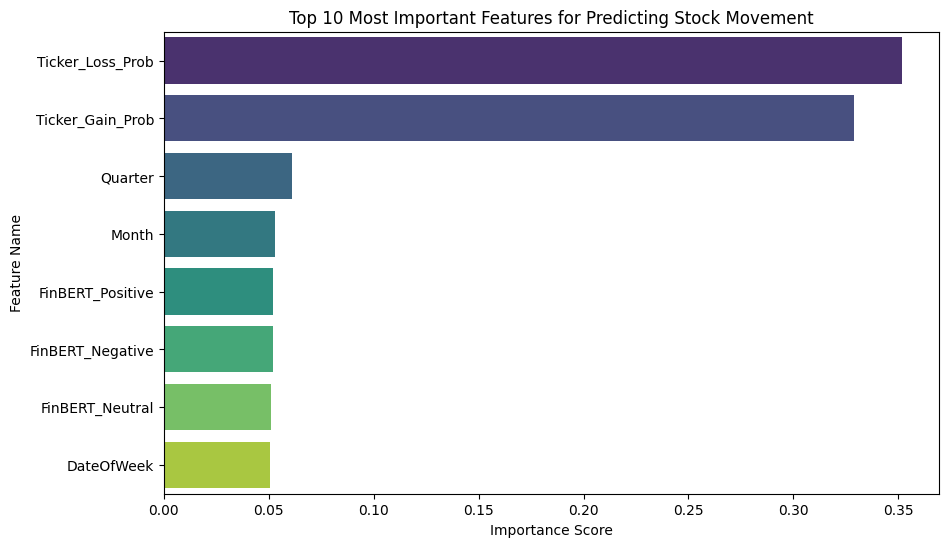

            Feature  Importance
7  Ticker_Loss_Prob    0.351759
6  Ticker_Gain_Prob    0.328649
2           Quarter    0.061243
1             Month    0.052867
3  FinBERT_Positive    0.052172
4  FinBERT_Negative    0.051892
5   FinBERT_Neutral    0.051033
0        DateOfWeek    0.050384


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
importances = best_model.feature_importances_

# Mapping scores to column names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Predicting Stock Movement')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

# Printing the raw data
print(feature_importance_df.head(10))

# **10 Threshold Tuning**

Class Order: ['Gain' 'Loss' 'Neutral']


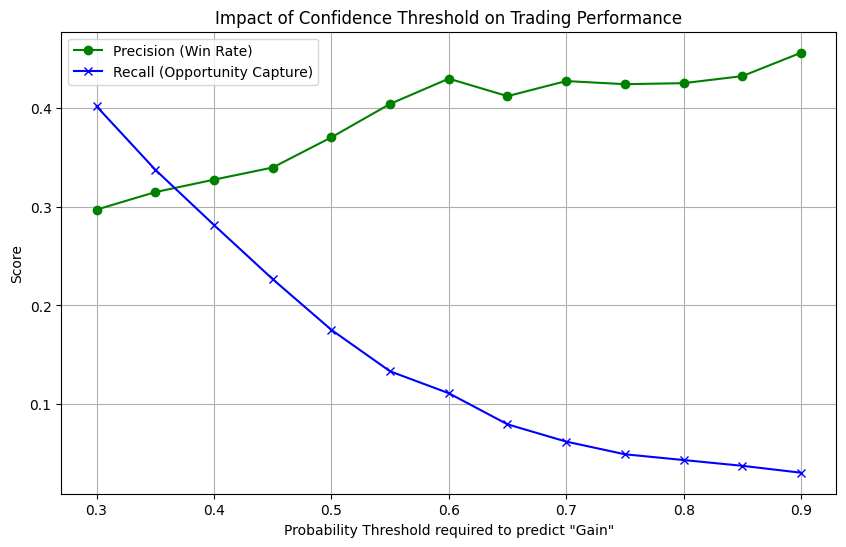

Threshold: 0.30 | Precision: 0.30 | Recall: 0.40
Threshold: 0.35 | Precision: 0.31 | Recall: 0.34
Threshold: 0.40 | Precision: 0.33 | Recall: 0.28
Threshold: 0.45 | Precision: 0.34 | Recall: 0.23
Threshold: 0.50 | Precision: 0.37 | Recall: 0.18
Threshold: 0.55 | Precision: 0.40 | Recall: 0.13
Threshold: 0.60 | Precision: 0.43 | Recall: 0.11
Threshold: 0.65 | Precision: 0.41 | Recall: 0.08
Threshold: 0.70 | Precision: 0.43 | Recall: 0.06
Threshold: 0.75 | Precision: 0.42 | Recall: 0.05
Threshold: 0.80 | Precision: 0.43 | Recall: 0.04
Threshold: 0.85 | Precision: 0.43 | Recall: 0.04
Threshold: 0.90 | Precision: 0.46 | Recall: 0.03


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Getting Probabilities instead of Class Labels
# This returns an array with 3 columns: [Prob_Gain, Prob_Loss, Prob_Neutral]
y_probs = best_model.predict_proba(X_test_scaled)

print(f"Class Order: {le.classes_}")
gain_index = np.where(le.classes_ == 'Gain')[0][0]

# Testing Thresholds from 0.3 to 0.9
thresholds = np.arange(0.3, 0.95, 0.05)
precisions = []
recalls = []

# Ground truth for Gain (Binary: 1 if Gain, 0 if Loss/Neutral)
y_test_gain_binary = (y_test_decoded == 'Gain').astype(int)

for t in thresholds:
    # If Prob_Gain > t, predict 1, else 0
    custom_preds = (y_probs[:, gain_index] >= t).astype(int)
    # Calculating scores
    if np.sum(custom_preds) > 0: # Avoid division by zero
        p = precision_score(y_test_gain_binary, custom_preds)
        r = recall_score(y_test_gain_binary, custom_preds)
    else:
        p = 1.0
        r = 0.0

    precisions.append(p)
    recalls.append(r)

# Plotting the Trade-off of Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision (Win Rate)', marker='o', color='green')
plt.plot(thresholds, recalls, label='Recall (Opportunity Capture)', marker='x', color='blue')
plt.title('Impact of Confidence Threshold on Trading Performance')
plt.xlabel('Probability Threshold required to predict "Gain"')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


for t, p, r in zip(thresholds, precisions, recalls):
    print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f}")

**Download Files and get versions for Streamlit**

In [28]:
import os
import zipfile
from IPython.display import FileLink

files_to_download = [
    'final_xgb_model.joblib',
    'standard_scaler.joblib',
    'target_label_encoder.joblib',
    'ticker_gain_encoder.joblib',
    'ticker_loss_encoder.joblib',
    'cleaned_stock_data.csv'
]

zip_filename = 'project_artifacts.zip'

print(f"Zipping {len(files_to_download)} files into '{zip_filename}'...")
missing_files = []

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_download:
        if os.path.exists(file):
            zipf.write(file)
            print(f"  - Added: {file}")
        else:
            missing_files.append(file)
            print(f"Warning: '{file}' not found. Did you save it?")

if len(missing_files) == len(files_to_download):
    print("\nError: No files found to zip. Please re-run the saving steps.")
else:
    print(f"\nZip file created: {zip_filename}")
    try:
        from google.colab import files
        files.download(zip_filename)
        print("Downloading via Google Colab...")
    except ImportError:
        print("Kaggle Detected. Click the link below to download:")
        display(FileLink(zip_filename))

Zipping 6 files into 'project_artifacts.zip'...
  - Added: final_xgb_model.joblib
  - Added: standard_scaler.joblib
  - Added: target_label_encoder.joblib
  - Added: ticker_gain_encoder.joblib
  - Added: ticker_loss_encoder.joblib

Zip file created: project_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import xgboost
import sklearn
import joblib
print(f"XGBoost Version: {xgboost.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"Joblib Version: {joblib.__version__}")

XGBoost Version: 3.1.2
Scikit-Learn Version: 1.6.1
Joblib Version: 1.5.2
